In [31]:
import sys
import os
from typing import List, Dict, Tuple, Any

eval_folder_path = "exp/shadow_sasrec_on_sr_data_lr0.01_lstep20/AmazonBeauty_RightCutAugDefault_30K"
config_path = os.path.join(eval_folder_path, "config.yaml")
print_log_path = os.path.join(eval_folder_path, "exp_print.log")
evaluation_log_path = os.path.join(eval_folder_path, "eval_results.log")


In [32]:
def load_log_file(file_path : str) -> str:
    """
    Load the log file and return the content as string.
    """
    with open(file_path, 'r') as file:
        log_content = file.read()
    
    return log_content

In [33]:
## Federated Learning Infos
from federatedscope.core.configs.config import global_cfg, CfgNode
import ast

init_cfg = global_cfg.clone()
init_cfg.merge_from_file(config_path)

method_is_shadow = False
if init_cfg.federate.method == "shadow" :
    method_is_shadow = True
    proxy_client_num = init_cfg.federate.client_num
    client_num = init_cfg.federate.standalone_args.shadow_client_num
else :
    client_num = init_cfg.federate.client_num
total_round_num = init_cfg.federate.total_round_num
batch_or_epoch = init_cfg.train.batch_or_epoch
local_update_steps = init_cfg.train.local_update_steps
dataset = init_cfg.data.root
dataset_split_path = init_cfg.data.partitioned_df_path
eval_step = init_cfg.eval.freq
max_item_seq_length = init_cfg.data.max_sequence_length
item_column = init_cfg.data.item_column
user_column = init_cfg.data.user_column

## get log content
log_content = load_log_file(print_log_path)

2024-09-06 16:37:47,369 (cfg_data:148)WARNING: config `cfg.data.batch_size` will be removed in the future, use `cfg.dataloader.batch_size` instead.
2024-09-06 16:37:47,370 (cfg_data:148)WARNING: config `cfg.data.batch_size` will be removed in the future, use `cfg.dataloader.batch_size` instead.


In [34]:
## Sort Client via their sequence length and test item label frequency

user_via_label_item_freq = {}

label_item_freq_via_user = {
    "5" : [], "6" : [], "7" : [], "8" : [], "9" : [],
    "10_or_above" : [],
}

user_via_item_seq_length = {}

sequence_length_via_user = {
    "5" : [], "6" : [], "7" : [], "8" : [], "9" : [],
    "10_or_above" : [],
}


## load from split df file
import pandas as pd
test_df = pd.read_csv(os.path.join(dataset_split_path, "test.csv"))
## get the item label frequency
item_label_freq = test_df.groupby(item_column).size().reset_index(name='freq')

## get item frequency and split into 
## 5, 6, 7, 8, 9, 10_or_above

instance_count = 0
last_user_id = None
for i, user_id in enumerate(test_df[user_column].values):
    if last_user_id != user_id :
        if last_user_id :
            
            user_via_item_seq_length[last_user_id] = min(instance_count, max_item_seq_length)
            ## split user by length
            if instance_count == 5:
                sequence_length_via_user["5"].append(last_user_id)
            elif instance_count == 6:
                sequence_length_via_user["6"].append(last_user_id)
            elif instance_count == 7:
                sequence_length_via_user["7"].append(last_user_id)
            elif instance_count == 8:
                sequence_length_via_user["8"].append(last_user_id)
            elif instance_count == 9:
                sequence_length_via_user["9"].append(last_user_id)
            else :
                sequence_length_via_user["10_or_above"].append(last_user_id)
            ## split user by item label frequency
            current_label_item = test_df.iloc[i - 1][item_column]
            current_label_item_freq = item_label_freq[item_label_freq[item_column] == current_label_item]["freq"].values[0]
            user_via_label_item_freq[last_user_id] = current_label_item_freq
            if current_label_item_freq == 5:
                label_item_freq_via_user["5"].append(last_user_id)
            elif current_label_item_freq == 6:
                label_item_freq_via_user["6"].append(last_user_id)
            elif current_label_item_freq == 7:
                label_item_freq_via_user["7"].append(last_user_id)
            elif current_label_item_freq == 8:
                label_item_freq_via_user["8"].append(last_user_id)
            elif current_label_item_freq == 9:
                label_item_freq_via_user["9"].append(last_user_id)
            else :
                label_item_freq_via_user["10_or_above"].append(last_user_id)
        ## reset the instance count
        last_user_id = user_id
        instance_count = 0
    instance_count += 1
    
user_via_item_seq_length[last_user_id] = min(instance_count, max_item_seq_length)
## split user by length
if instance_count == 5:
    sequence_length_via_user["5"].append(last_user_id)
elif instance_count == 6:
    sequence_length_via_user["6"].append(last_user_id)
elif instance_count == 7:
    sequence_length_via_user["7"].append(last_user_id)
elif instance_count == 8:
    sequence_length_via_user["8"].append(last_user_id)
elif instance_count == 9:
    sequence_length_via_user["9"].append(last_user_id)
else :
    sequence_length_via_user["10_or_above"].append(last_user_id)
## split user by item label frequency
current_label_item = test_df.tail(1)[item_column].values[0]
current_label_item_freq = item_label_freq[item_label_freq[item_column] == current_label_item]["freq"].values[0]
user_via_label_item_freq[last_user_id] = current_label_item_freq
if current_label_item_freq == 5:
    label_item_freq_via_user["5"].append(last_user_id)
elif current_label_item_freq == 6:
    label_item_freq_via_user["6"].append(last_user_id)
elif current_label_item_freq == 7:
    label_item_freq_via_user["7"].append(last_user_id)
elif current_label_item_freq == 8:
    label_item_freq_via_user["8"].append(last_user_id)
elif current_label_item_freq == 9:
    label_item_freq_via_user["9"].append(last_user_id)
else :
    label_item_freq_via_user["10_or_above"].append(last_user_id)


Min Sequence Length :  5
Max Sequence Length :  50
Mean Sequence Length :  8.705763985154048


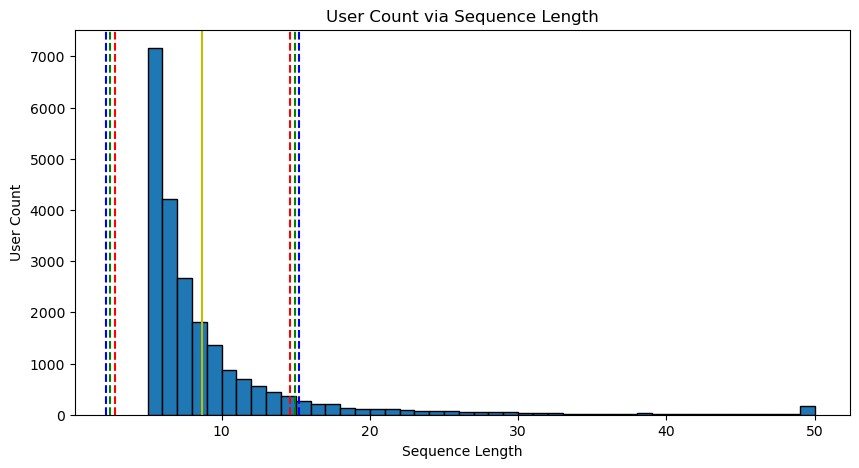

Sequence Length OOD :  2.205645438515213
   alpha  sequence_length
0   0.10         2.796565
1   0.05         2.468276
2   0.01         2.205645


In [35]:
min_sequence_length = min(user_via_item_seq_length.values())
max_sequence_length = max(user_via_item_seq_length.values())
mean_sequence_length = sum(user_via_item_seq_length.values()) / len(user_via_item_seq_length)

print("Min Sequence Length : ", min_sequence_length)
print("Max Sequence Length : ", max_sequence_length)
print("Mean Sequence Length : ", mean_sequence_length)

## show long tail distribution to determine the sequence length ood
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
## range form Min to Max
plt.hist(user_via_item_seq_length.values(), bins=range(min_sequence_length, max_sequence_length + 1), edgecolor='black')
plt.xlabel("Sequence Length")
plt.ylabel("User Count")
plt.title("User Count via Sequence Length")

sequence_left_tail_1e_1 = mean_sequence_length - np.std(list(user_via_item_seq_length.values())) * (1 - 0.1)
sequence_right_tail_1e_1 = mean_sequence_length + np.std(list(user_via_item_seq_length.values())) * (1 - 0.1)
sequence_left_tail_5e_2 = mean_sequence_length - np.std(list(user_via_item_seq_length.values())) * (1 - 0.05)
sequence_right_tail_5e_2 = mean_sequence_length + np.std(list(user_via_item_seq_length.values())) * (1- 0.05)
sequence_left_tail_1e_2 = mean_sequence_length - np.std(list(user_via_item_seq_length.values())) * (1 - 0.01)
sequence_right_tail_1e_2 = mean_sequence_length + np.std(list(user_via_item_seq_length.values())) * (1-0.01)

## plot the mean
plt.axvline(x=mean_sequence_length, color='y', linestyle='-', label='Mean')

## plot the tail
plt.axvline(x=sequence_left_tail_1e_1, color='r', linestyle='--', label='0.1')
plt.axvline(x=sequence_right_tail_1e_1, color='r', linestyle='--')
plt.axvline(x=sequence_left_tail_5e_2, color='g', linestyle='--', label='0.05')
plt.axvline(x=sequence_right_tail_5e_2, color='g', linestyle='--')
plt.axvline(x=sequence_left_tail_1e_2, color='b', linestyle='--', label='0.01')
plt.axvline(x=sequence_right_tail_1e_2, color='b', linestyle='--')

plt.show()

## determine the sequence length ood
import numpy as np
import pandas as pd
sequence_length_ood = sequence_left_tail_1e_2

df_sequence_length_left_tail = pd.DataFrame({
    "alpha" : [0.1, 0.05, 0.01],
    "sequence_length" : [sequence_left_tail_1e_1, sequence_left_tail_5e_2, sequence_left_tail_1e_2],
})
print("Sequence Length OOD : ", sequence_length_ood)
print(df_sequence_length_left_tail)
sequence_length_ood_threshold = sequence_length_ood



Min Item Label Frequency :  5
Max Item Label Frequency :  431
Mean Item Label Frequency :  40.97030809819792


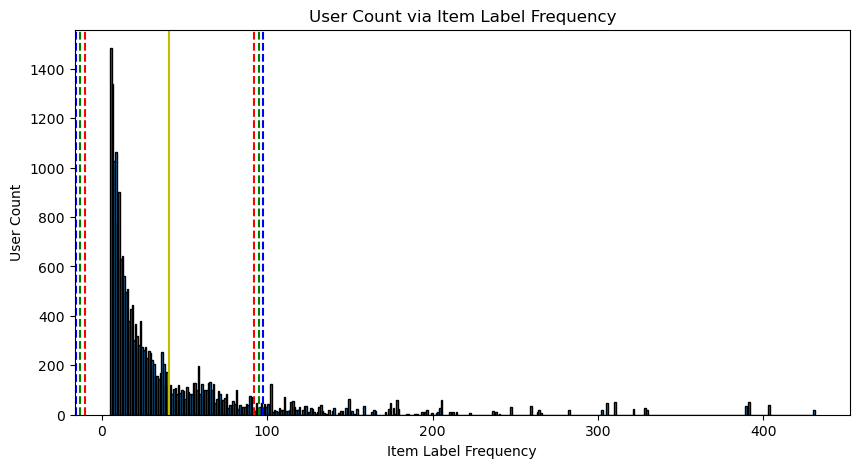

Item Label Frequency OOD :  -15.3173104300785
   alpha  item_label_freq
0   0.10       -10.200254
1   0.05       -13.043063
2   0.01       -15.317310


In [36]:
max_item_label_freq = max(user_via_label_item_freq.values())
min_item_label_freq = min(user_via_label_item_freq.values())
mean_item_label_freq = sum(user_via_label_item_freq.values()) / len(user_via_label_item_freq)

label_freq_left_tail_1e_1 = mean_item_label_freq - np.std(list(user_via_label_item_freq.values())) * (1 - 0.1)
label_freq_right_tail_1e_1 = mean_item_label_freq + np.std(list(user_via_label_item_freq.values())) * (1 - 0.1)
label_freq_left_tail_5e_2 = mean_item_label_freq - np.std(list(user_via_label_item_freq.values())) * (1 - 0.05)
label_freq_right_tail_5e_2 = mean_item_label_freq + np.std(list(user_via_label_item_freq.values())) * (1- 0.05)
label_freq_left_tail_1e_2 = mean_item_label_freq - np.std(list(user_via_label_item_freq.values())) * (1 - 0.01)
label_freq_right_tail_1e_2 = mean_item_label_freq + np.std(list(user_via_label_item_freq.values())) * (1-0.01)


print("Min Item Label Frequency : ", min_item_label_freq)
print("Max Item Label Frequency : ", max_item_label_freq)
print("Mean Item Label Frequency : ", mean_item_label_freq)

plt.figure(figsize=(10, 5))
## range form Min to Max
plt.hist(user_via_label_item_freq.values(), bins=range(min_item_label_freq, max_item_label_freq + 1), edgecolor='black')

plt.xlabel("Item Label Frequency")
plt.ylabel("User Count")
plt.title("User Count via Item Label Frequency")

## plot the mean
plt.axvline(x=mean_item_label_freq, color='y', linestyle='-', label='Mean')

## plot the tail
plt.axvline(x=label_freq_left_tail_1e_1, color='r', linestyle='--', label='0.1')
plt.axvline(x=label_freq_right_tail_1e_1, color='r', linestyle='--')
plt.axvline(x=label_freq_left_tail_5e_2, color='g', linestyle='--', label='0.05')
plt.axvline(x=label_freq_right_tail_5e_2, color='g', linestyle='--')
plt.axvline(x=label_freq_left_tail_1e_2, color='b', linestyle='--', label='0.01')
plt.axvline(x=label_freq_right_tail_1e_2, color='b', linestyle='--')

plt.show()


## determine the item label frequency ood
item_label_freq_ood = label_freq_left_tail_1e_2
print("Item Label Frequency OOD : ", item_label_freq_ood)

df_item_label_freq_left_tail = pd.DataFrame({
    "alpha" : [0.1, 0.05, 0.01],
    "item_label_freq" : [label_freq_left_tail_1e_1, label_freq_left_tail_5e_2, label_freq_left_tail_1e_2],
})
print(df_item_label_freq_left_tail)


item_label_freq_ood_threshold = item_label_freq_ood

In [37]:
import ast
import re

#local_results = log_content.split('(client:354)')[1:]

## if key the line has '(client:354)' or '(sr_sybil_attack_server:560)' then that line is a hit
local_train_report = []
for line in log_content.split('\n') :
    if '(client:354)' in line or '(sr_sybil_attack_server:579)' in line :
        local_train_report.append(line)

#sprint(len(local_train_report))
#print(local_train_report[0])
## Split content by 'INFO: ' and convert to dictionary
refined_local_results = []

for local_result in local_train_report :
    refined_str = local_result.split('INFO: ')[1]
    refined_dict = ast.literal_eval(refined_str)
    refined_local_results.append(refined_dict)

print(len(refined_local_results))
print(refined_local_results[0]['Round'])



480000
0


In [38]:
## aggregate the results by round

clients_result = []

def parse_client_id(role : str) -> int :
    """
    Parse the client id from the role string such as 'Client #593'.
    """
    return int(role.split('#')[1])

for line_num, local_result in enumerate(refined_local_results):
    current_id = parse_client_id(local_result['Role'])
    clients_result.append(local_result)

print(len(clients_result))


480000


In [39]:
import numpy as np

## x-axis : round, y-axis : loss mean, std, max, min
## for each round loss values are
train_loss_via_round = {i : [] for i in range(total_round_num)}
sequence_length_ood_via_round = {i : 0 for i in range(total_round_num)}
label_item_freq_ood_via_round = {i : 0 for i in range(total_round_num)}

## numerical sequence length via round & label item frequency via round
print("tracking sequence length and label item frequency via round")

sequence_length_upper_bound = max_item_seq_length
sequence_length_n_via_round = [{i : 0 for i in range(total_round_num)} for _ in range(sequence_length_upper_bound - min_sequence_length)]
print("sequence_length_from : ", min_sequence_length, " to ", sequence_length_upper_bound)

label_freq_upper_bound = int(min(max_item_label_freq, label_freq_right_tail_1e_2))
label_freq_n_via_round = [{i : 0 for i in range(total_round_num)} for _ in range(label_freq_upper_bound - min_item_label_freq)]
print("label_item_freq_from : ", min_item_label_freq, " to ", label_freq_upper_bound)

for local_result in clients_result:
    client_id = parse_client_id(local_result['Role'])
    current_round = local_result['Round']
    train_loss_via_round[current_round].append(local_result['Results_raw']['train_avg_loss'])
    
    current_sequence_length = user_via_item_seq_length[client_id]
    for i in range(current_sequence_length - min_sequence_length, sequence_length_upper_bound - min_sequence_length) :
        sequence_length_n_via_round[i][current_round] += 1
    
    current_label_item_freq = user_via_label_item_freq[client_id]
    for i in range(current_label_item_freq-min_item_label_freq, label_freq_upper_bound - min_item_label_freq) :
        label_freq_n_via_round[i][current_round] += 1

train_loss = [value for key, value in train_loss_via_round.items()]
avg_train_loss = [np.mean(value) for value in train_loss]
std_train_loss = [np.std(value) for value in train_loss]

tracking sequence length and label item frequency via round
sequence_length_from :  5  to  50
label_item_freq_from :  5  to  97


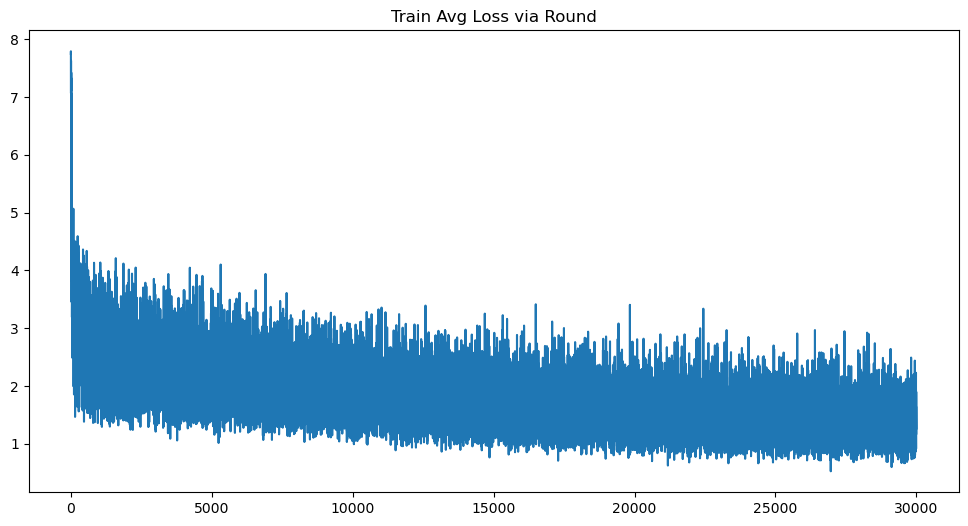

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## draw avg train loss plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(total_round_num), avg_train_loss, label='Average Train Loss')
plt.title("Train Avg Loss via Round")
plt.show()



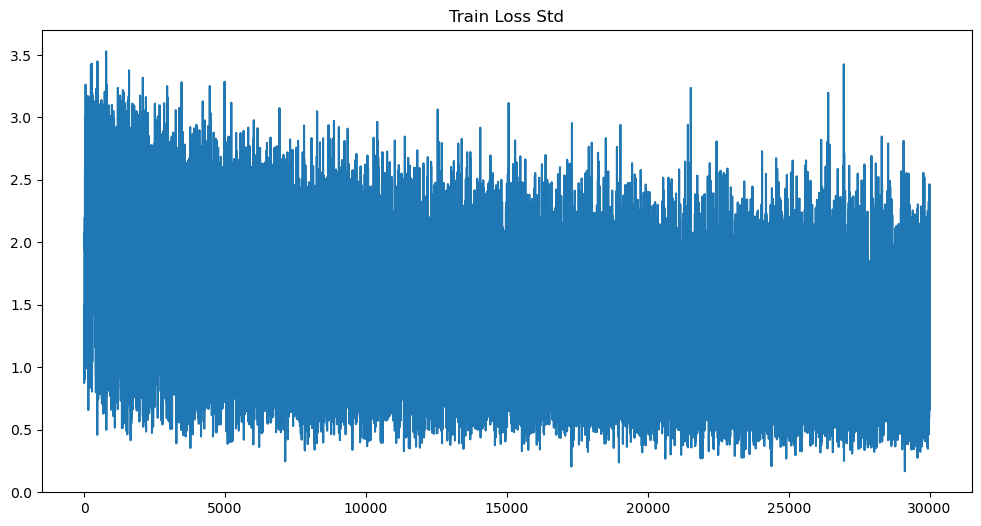

In [41]:
## draw train std loss plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(total_round_num), std_train_loss, label='Train Loss Std')
plt.title("Train Loss Std")
plt.show()



Pearson Correlation for Sequence Length OOD
    pearson_corr  ood_threshold
0      -0.344074              5
1      -0.449758              6
2      -0.509911              7
3      -0.547214              8
4      -0.569790              9
5      -0.579541             10
6      -0.587773             11
7      -0.590615             12
8      -0.582039             13
9      -0.573840             14
10     -0.561174             15
11     -0.550331             16
12     -0.537246             17
13     -0.522915             18
14     -0.508261             19
15     -0.491946             20
16     -0.470992             21
17     -0.456497             22
18     -0.442151             23
19     -0.422693             24
20     -0.403243             25
21     -0.382868             26
22     -0.367338             27
23     -0.353696             28
24     -0.343108             29
25     -0.328976             30
26     -0.317746             31
27     -0.306501             32
28     -0.297838            

Text(0.5, 1.0, 'Pearson Correlation for Sequence Length OOD')

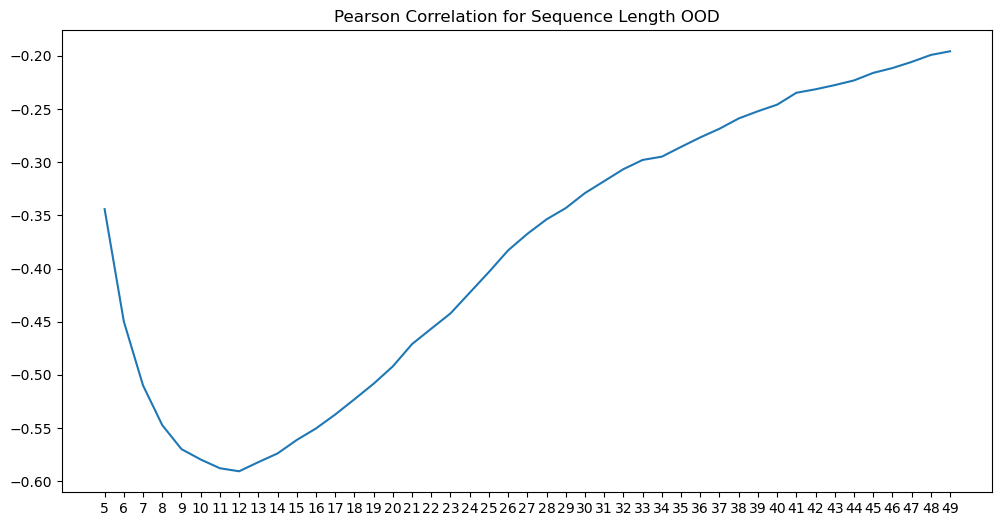

In [42]:
## see if the ood counts have correlation with the mean train loss 

## pearson correlation for 20 ood counts and mean train loss
## Conduct Pearson Correlation Test
from scipy.stats import pearsonr

peasron_corr_via_sequence_length_ood = {
    "pearson_corr" : [],
    "ood_threshold" : [],
}

for i, current_sequence_length_via_round in enumerate(sequence_length_n_via_round) :
    ood_count_per_round = list(current_sequence_length_via_round.values())
    pearson_corr, _ = pearsonr(ood_count_per_round, avg_train_loss)
    peasron_corr_via_sequence_length_ood["pearson_corr"].append(pearson_corr)
    peasron_corr_via_sequence_length_ood["ood_threshold"].append(i+min_sequence_length)

df_pearson_corr_sequence_length_ood = pd.DataFrame(peasron_corr_via_sequence_length_ood)
print("Pearson Correlation for Sequence Length OOD")
print(df_pearson_corr_sequence_length_ood)
df_pearson_corr_sequence_length_ood.to_csv("AmazonBeauty_pearson_corr_sequence_length_ood.csv")
## into the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(min_sequence_length, sequence_length_upper_bound), peasron_corr_via_sequence_length_ood["pearson_corr"], label='Pearson Correlation')
plt.xticks(range(min_sequence_length, sequence_length_upper_bound))
plt.title("Pearson Correlation for Sequence Length OOD")



Pearson Correlation for Label Item Frequency OOD
    pearson_corr  ood_threshold
0      -0.004796              5
1      -0.006671              6
2      -0.011160              7
3      -0.017545              8
4      -0.022609              9
..           ...            ...
87      0.012382             92
88      0.013520             93
89      0.013820             94
90      0.013178             95
91      0.012573             96

[92 rows x 2 columns]


Text(0.5, 1.0, 'Pearson Correlation for Label Item Frequency OOD')

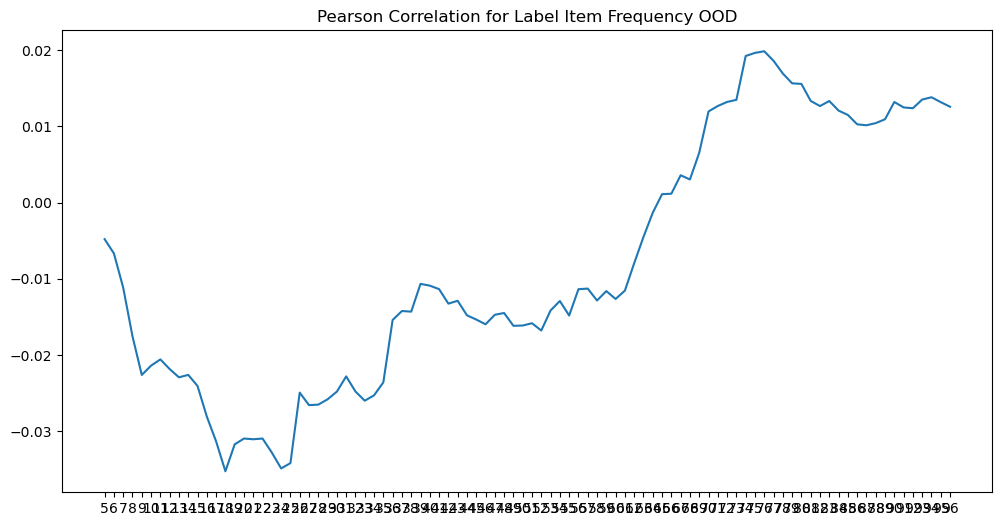

In [43]:
## see if the ood counts have correlation with the mean train loss 

## pearson correlation for 20 ood counts and mean train loss
## Conduct Pearson Correlation Test
from scipy.stats import pearsonr

peasron_corr_via_label_freq_ood = {
    "pearson_corr" : [],
    "ood_threshold" : [],
}

for i, current_label_item_feq_via_round in enumerate(label_freq_n_via_round) :
    ood_count_per_round = list(current_label_item_feq_via_round.values())
    pearson_corr, _ = pearsonr(ood_count_per_round, avg_train_loss)
    peasron_corr_via_label_freq_ood["pearson_corr"].append(pearson_corr)
    peasron_corr_via_label_freq_ood["ood_threshold"].append(i + min_item_label_freq)

df_pearson_corr_label_freq_ood = pd.DataFrame(peasron_corr_via_label_freq_ood)
print("Pearson Correlation for Label Item Frequency OOD")
print(df_pearson_corr_label_freq_ood)
df_pearson_corr_label_freq_ood.to_csv(f"AmazonBeauty_pearson_corr_label_freq_ood.csv")

## into the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(min_item_label_freq, label_freq_upper_bound), peasron_corr_via_label_freq_ood["pearson_corr"], label='Pearson Correlation')
plt.xticks(range(min_item_label_freq, label_freq_upper_bound))
plt.title("Pearson Correlation for Label Item Frequency OOD")




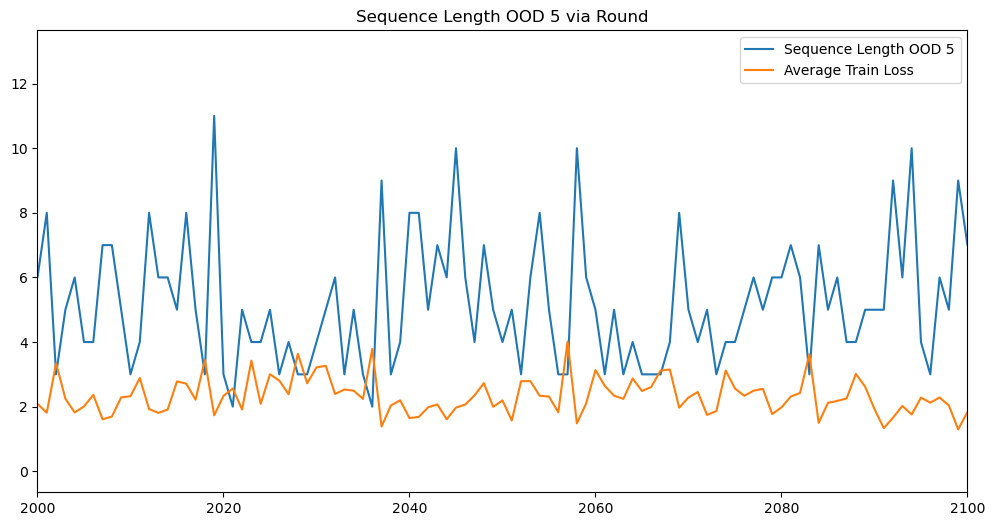

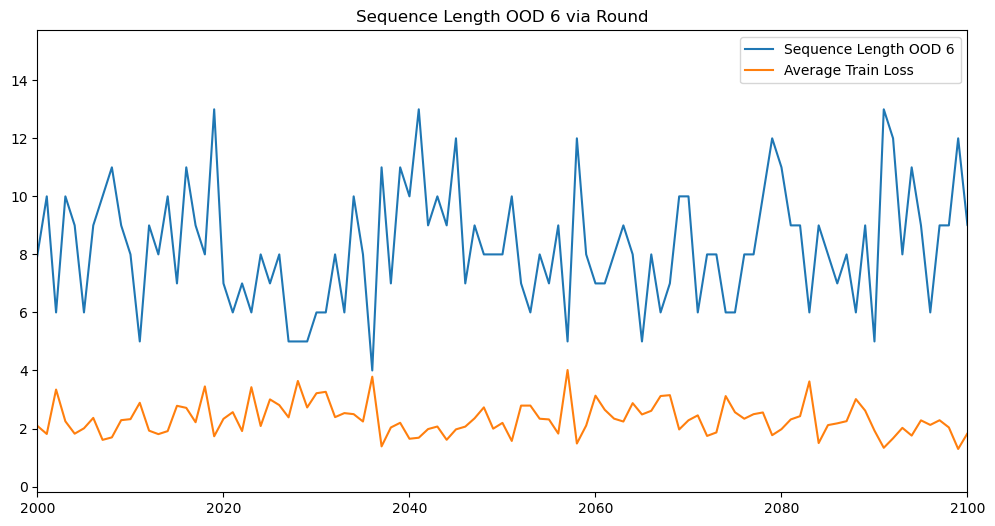

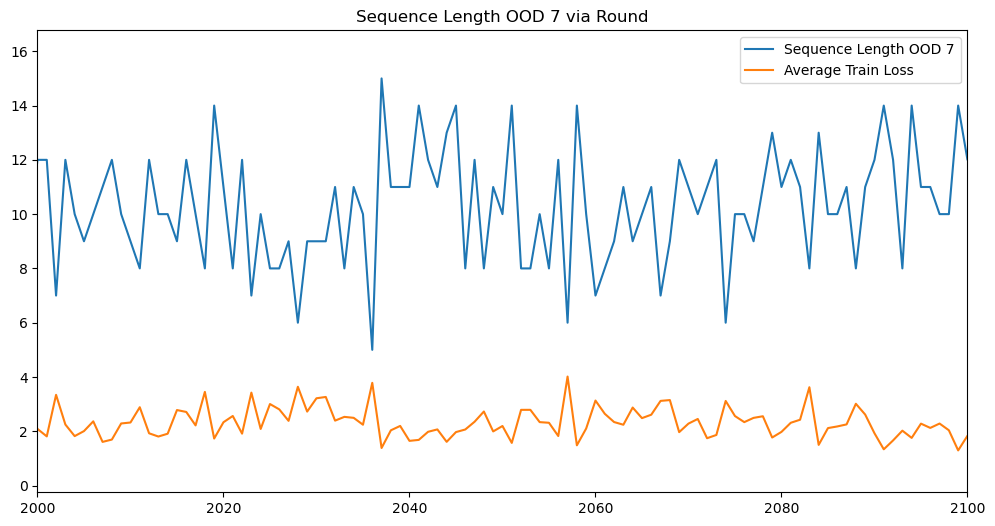

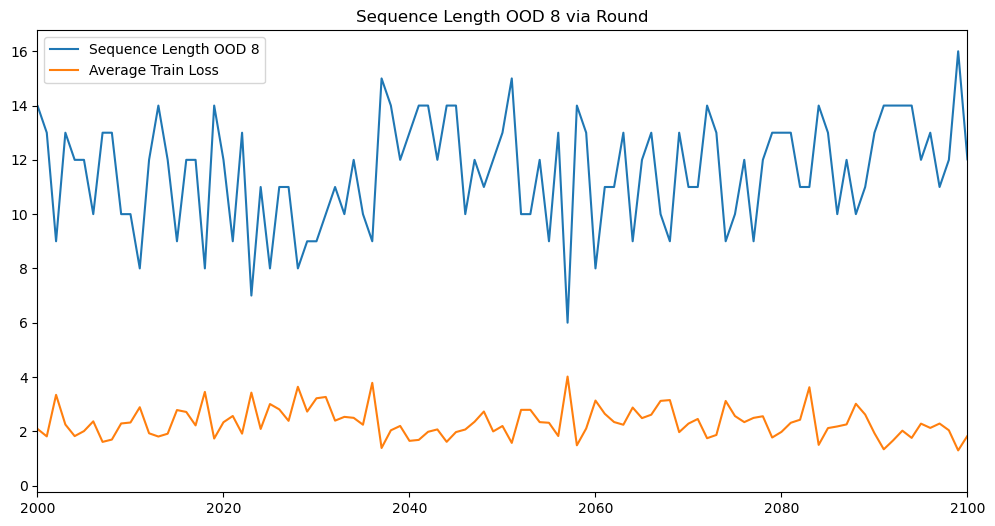

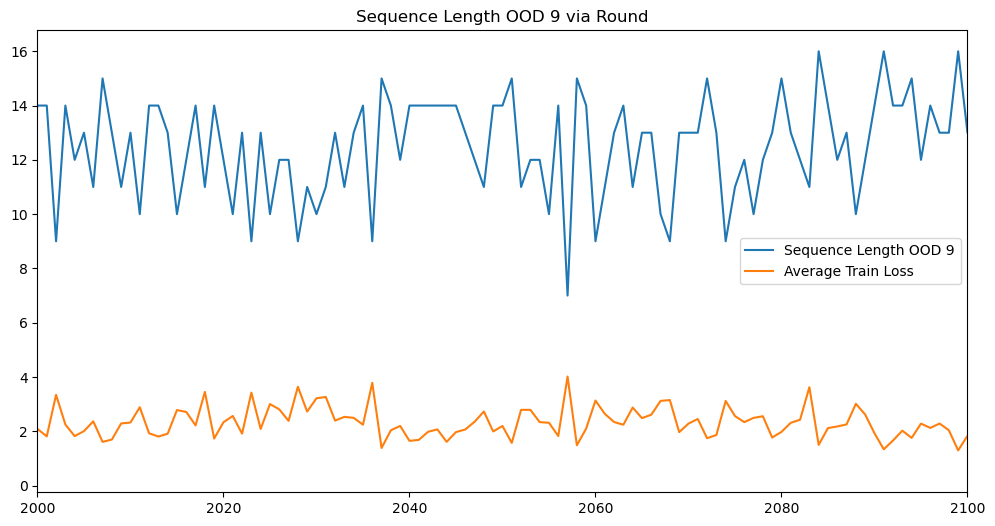

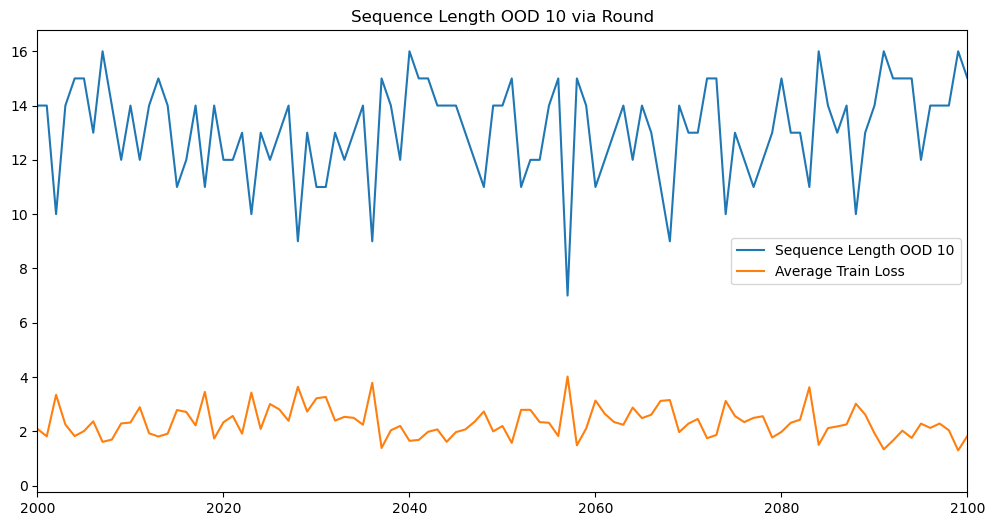

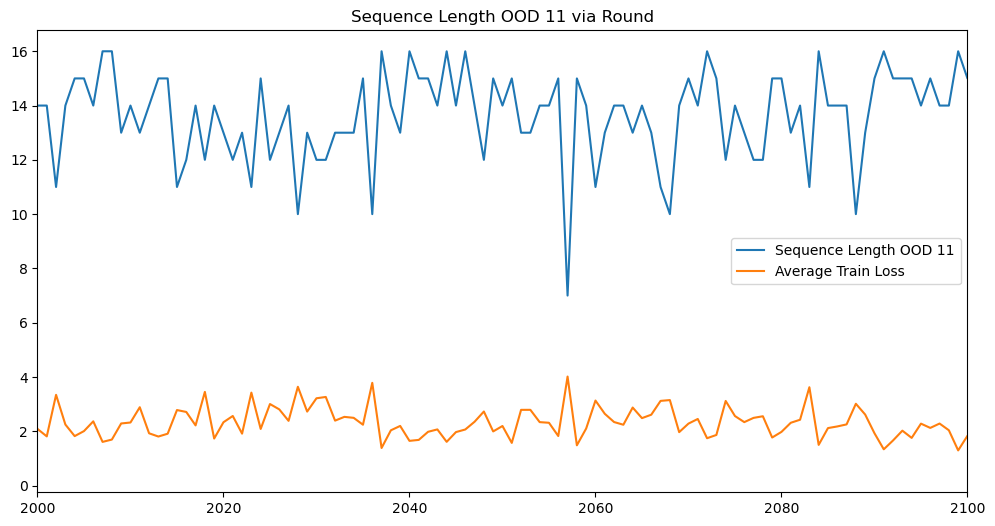

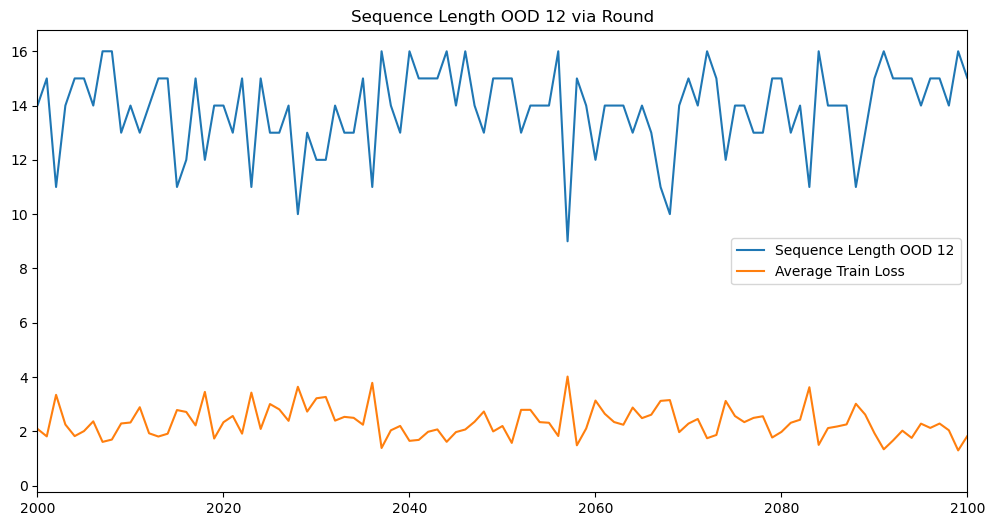

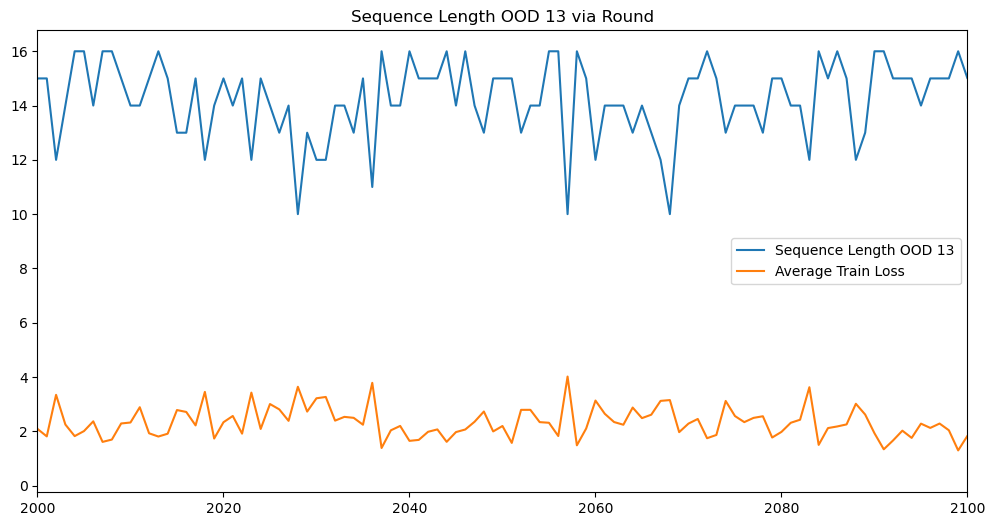

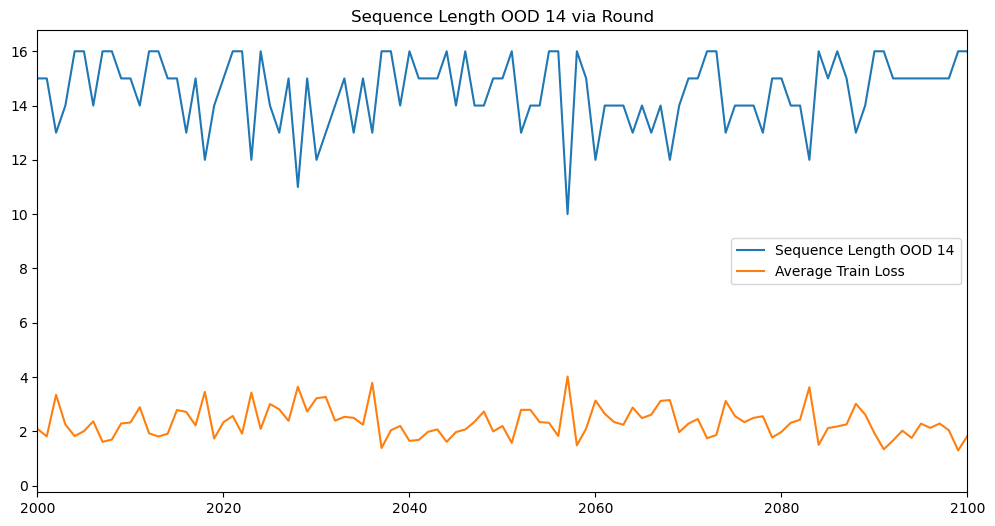

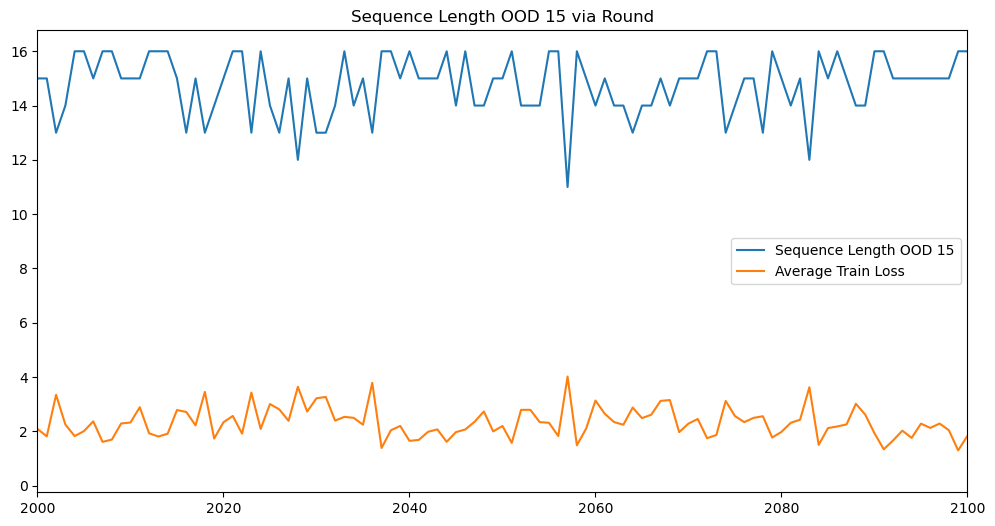

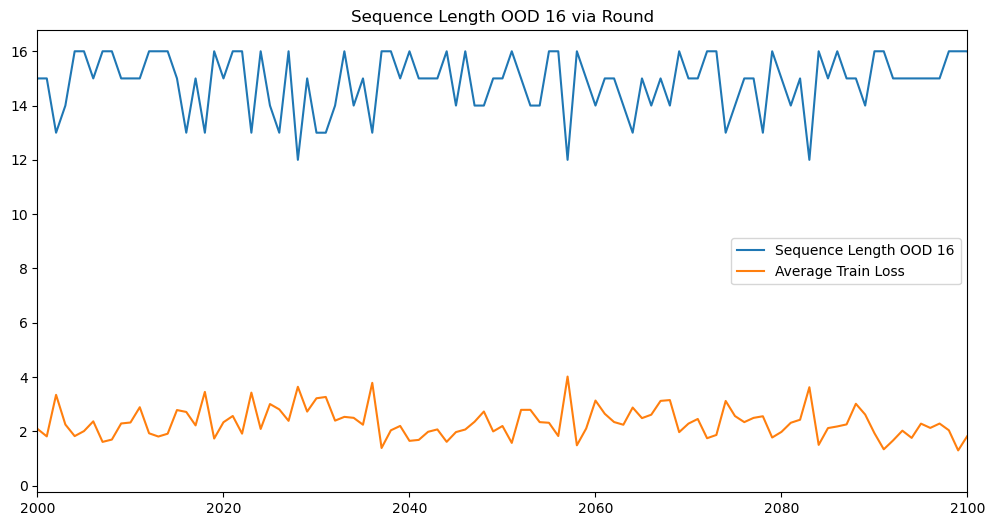

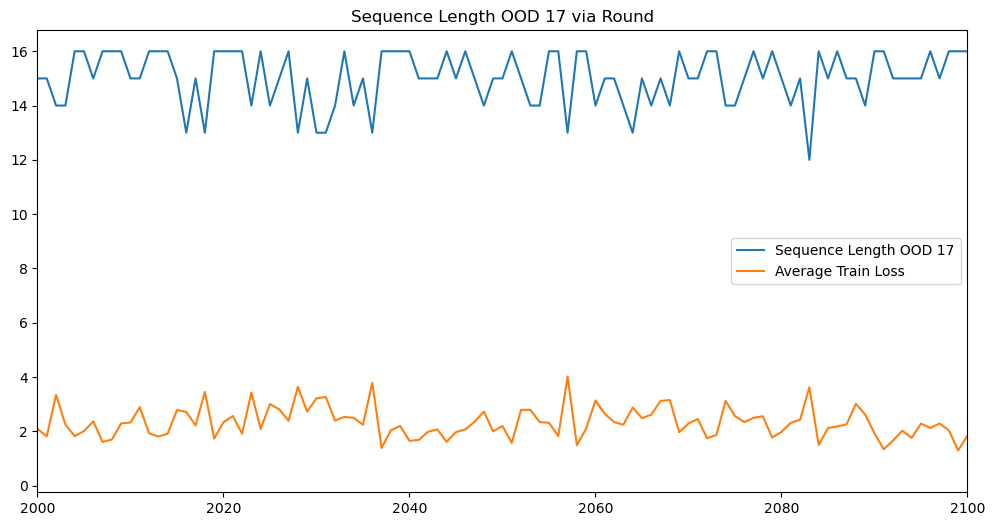

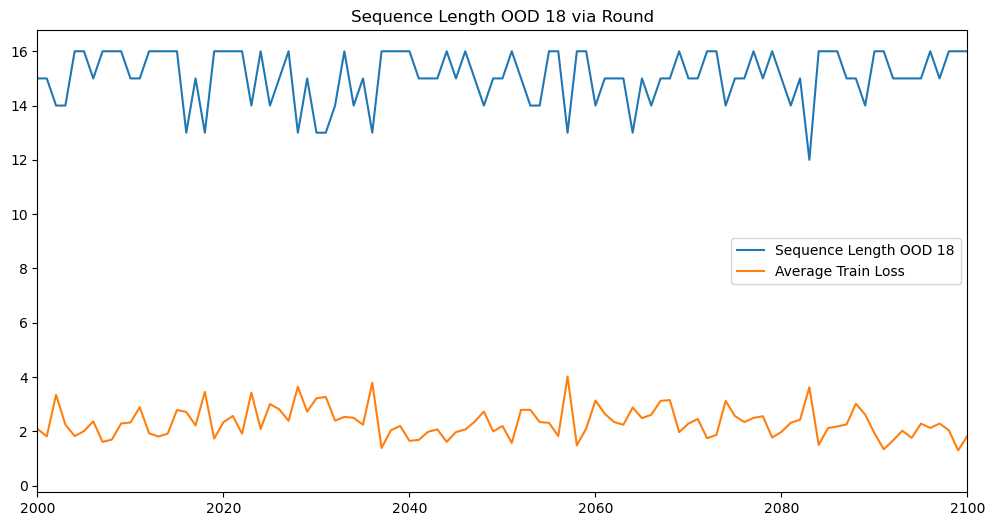

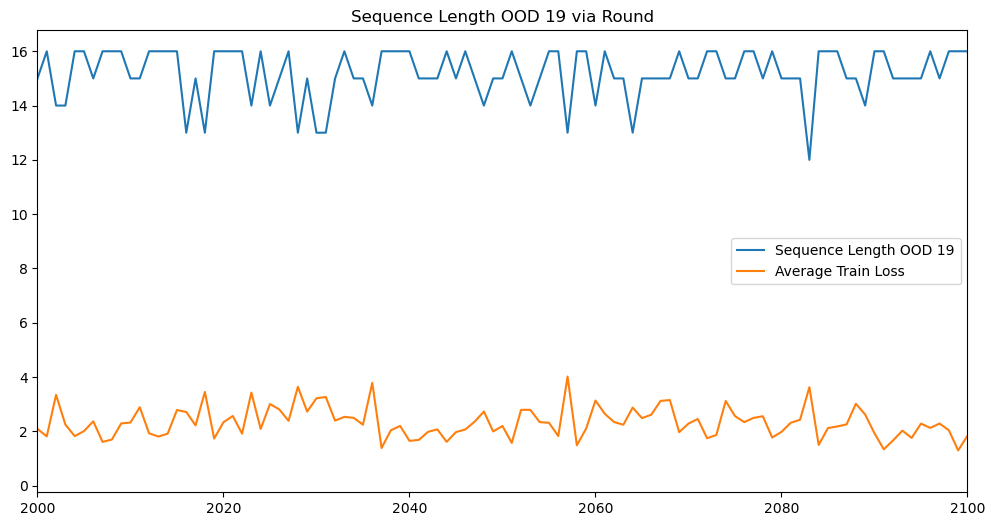

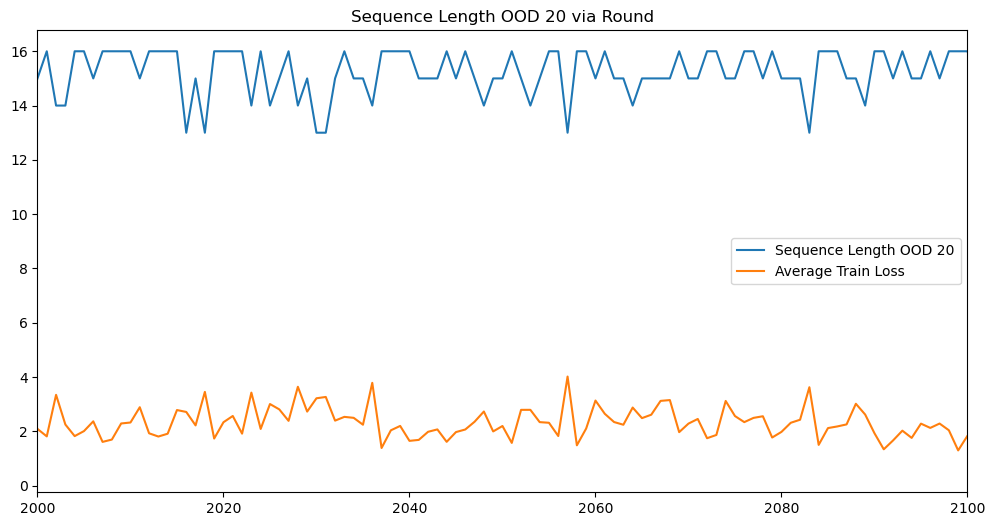

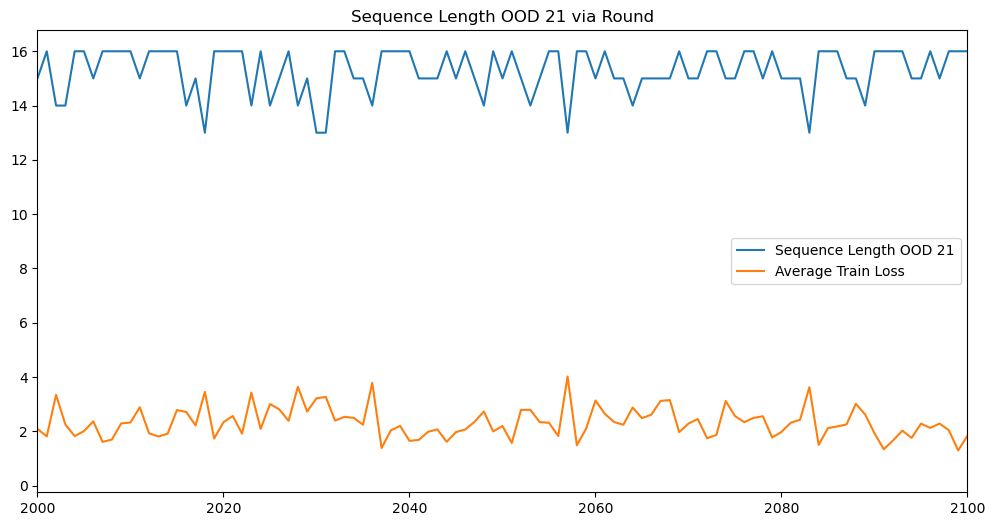

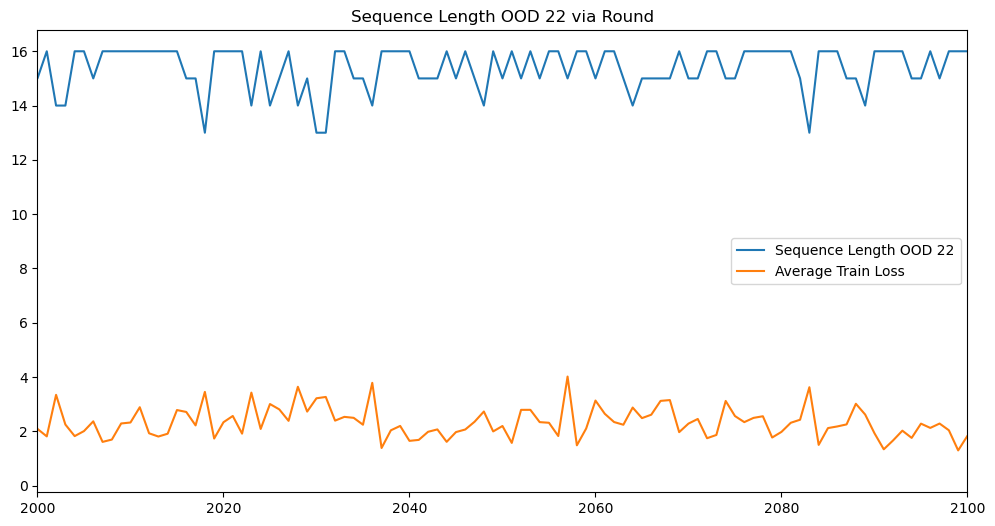

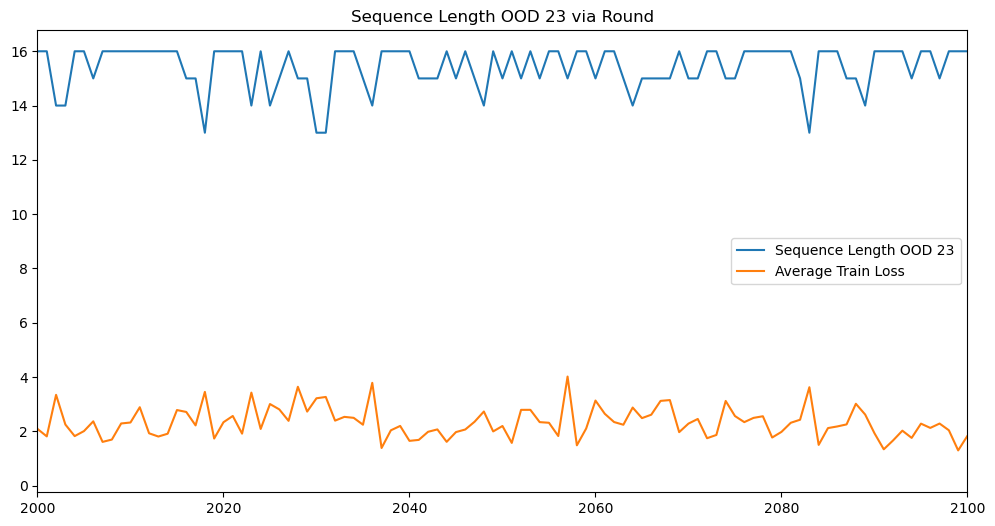

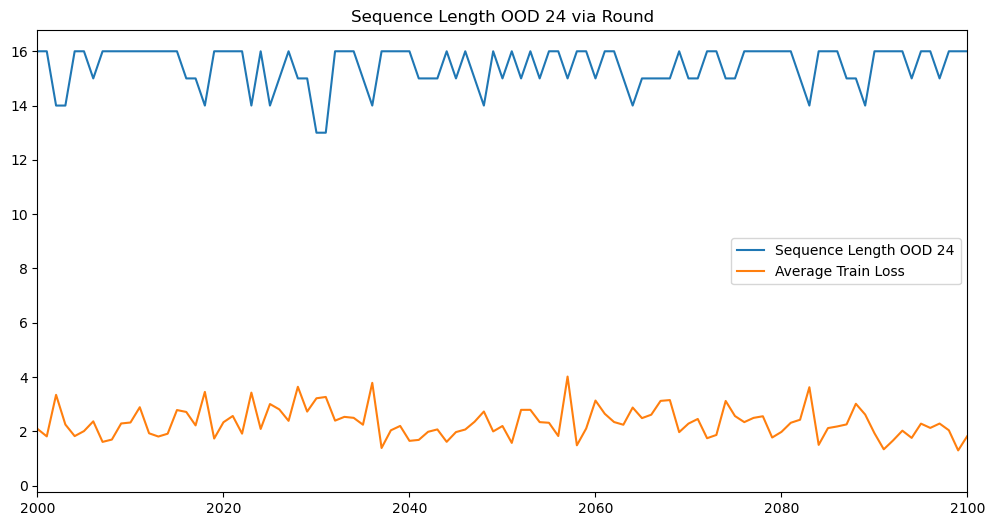

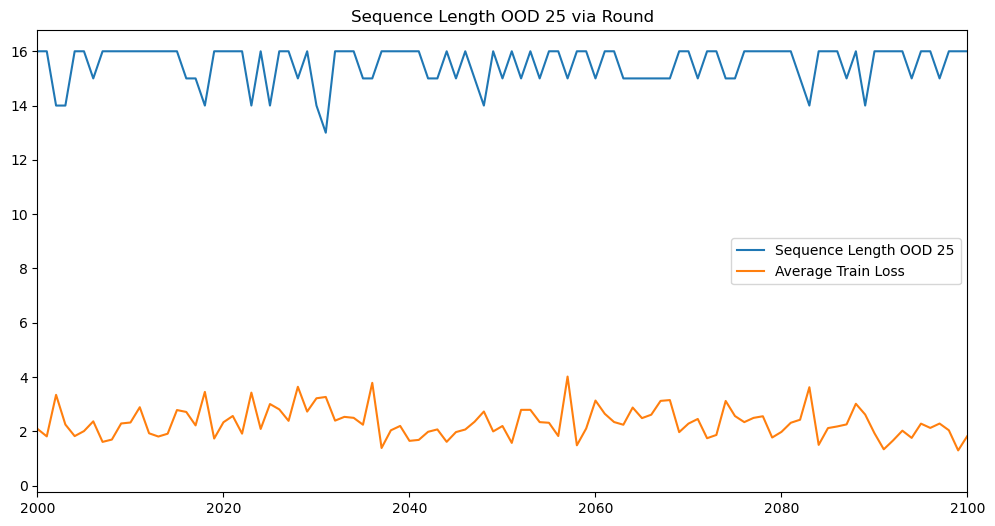

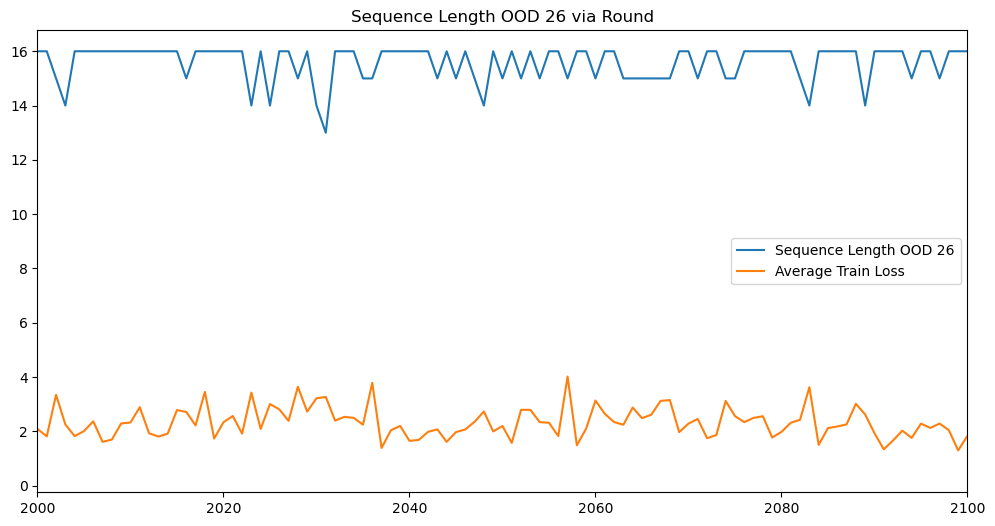

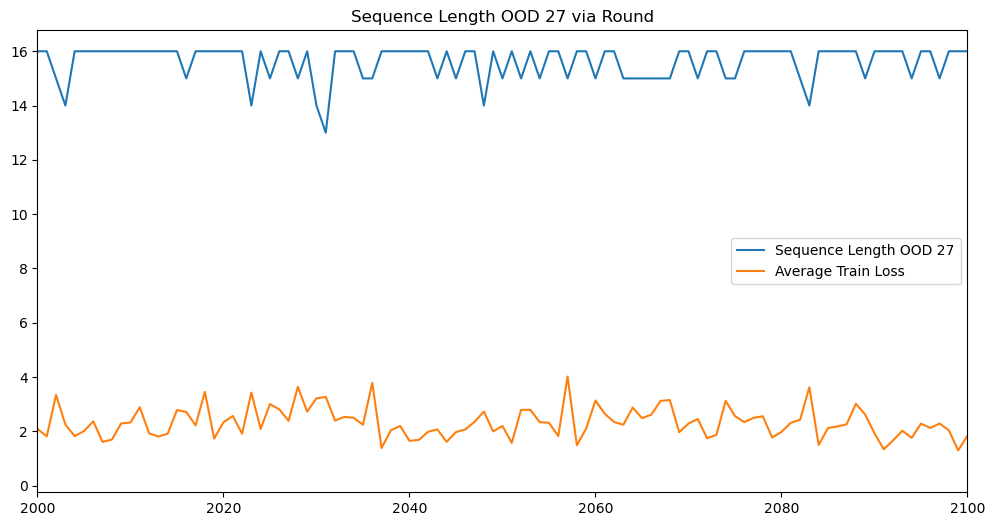

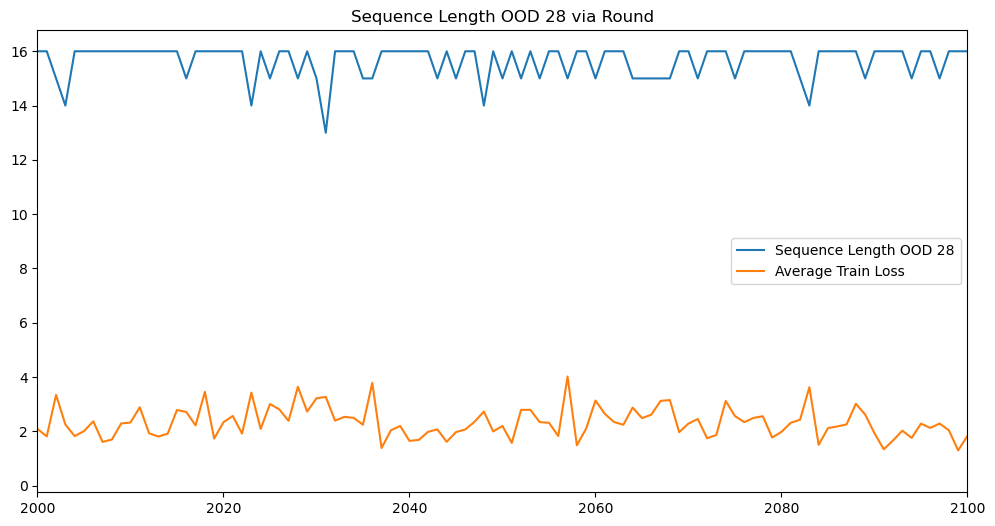

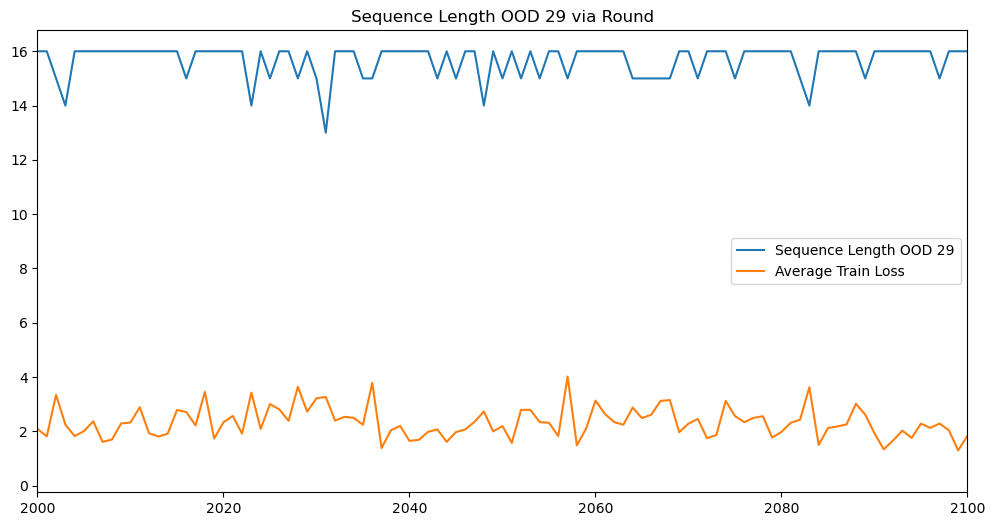

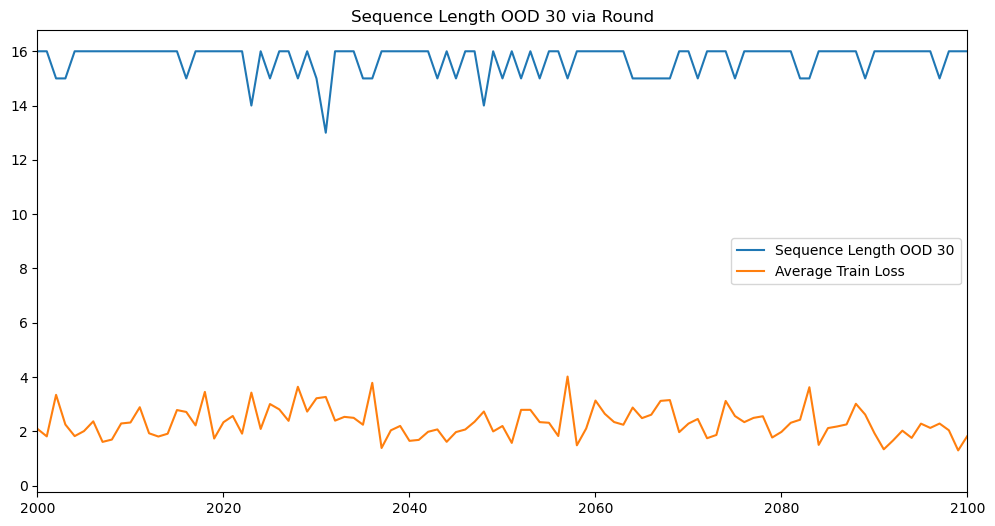

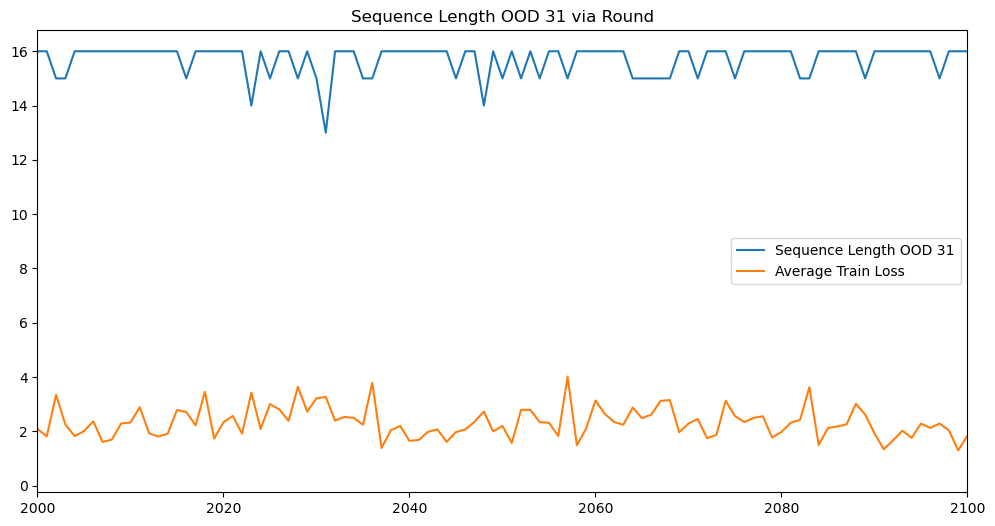

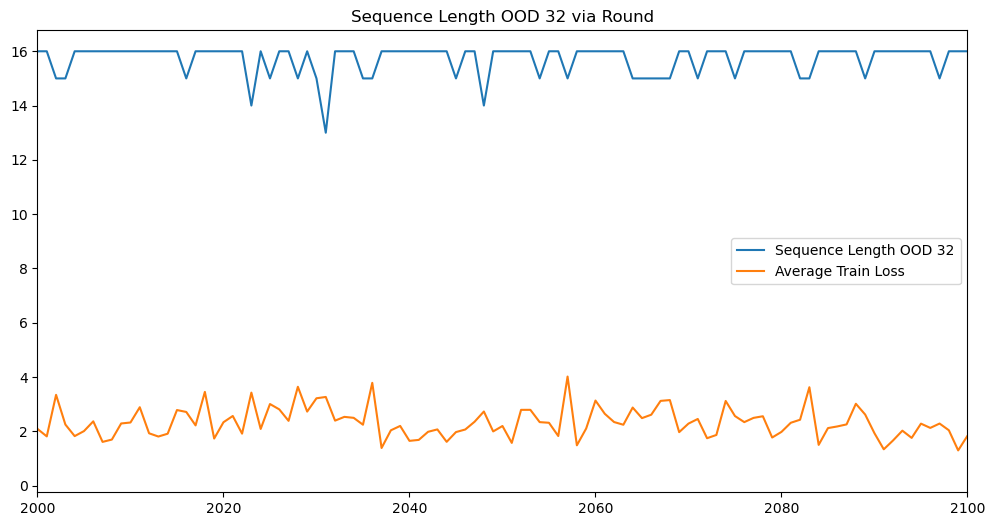

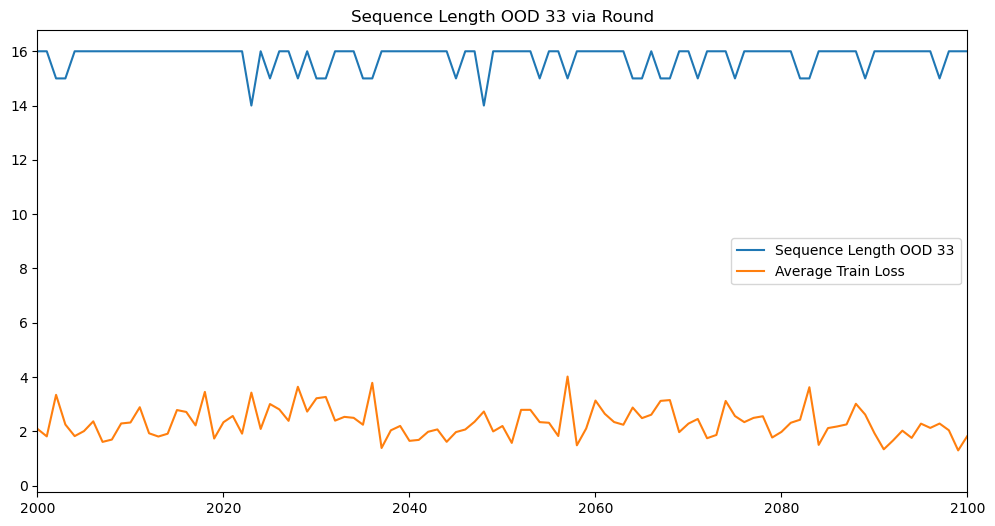

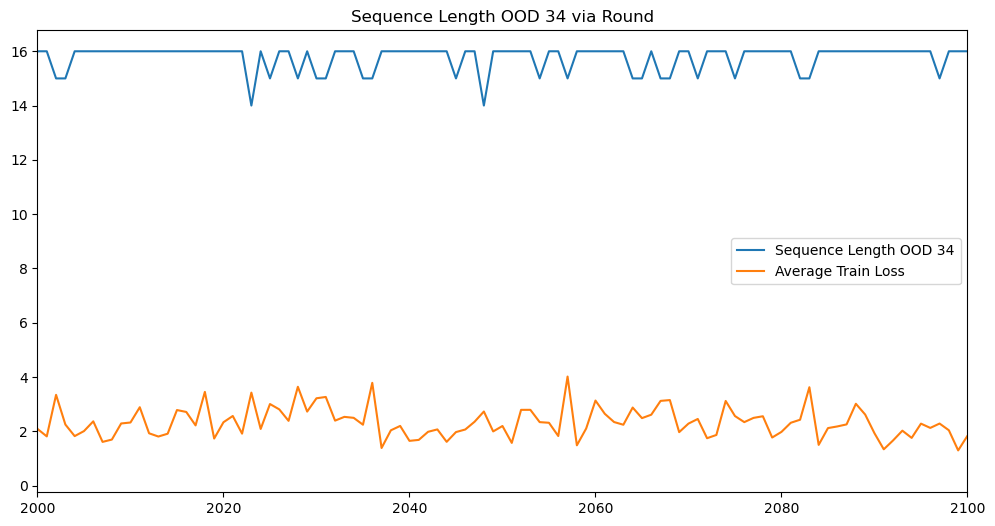

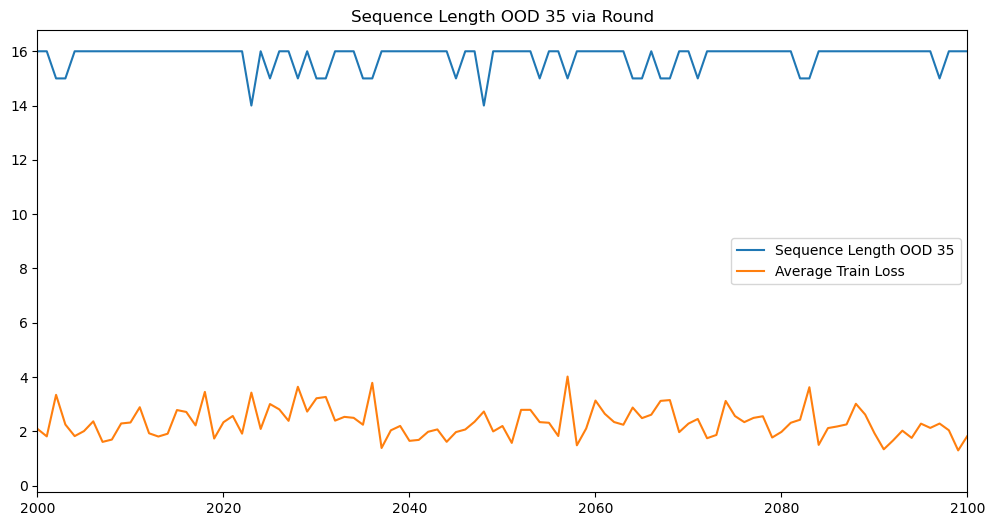

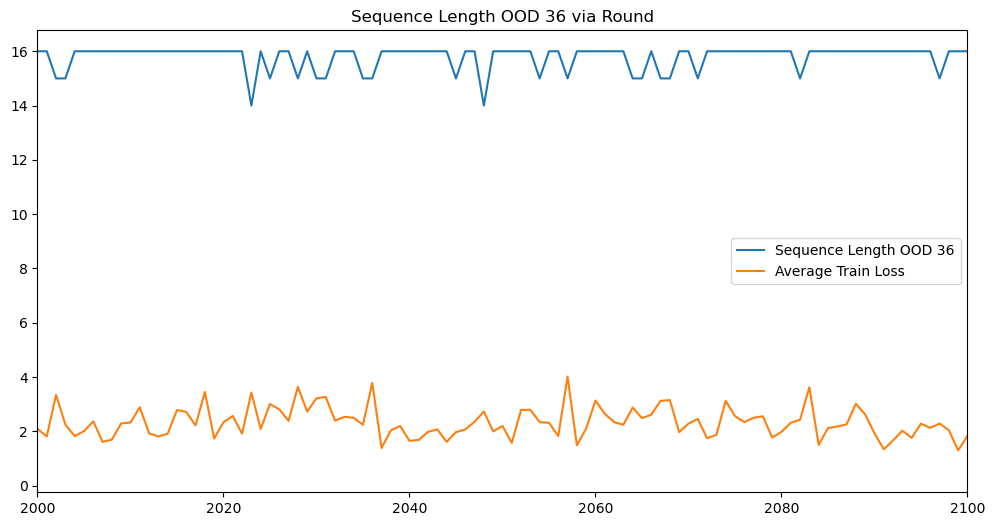

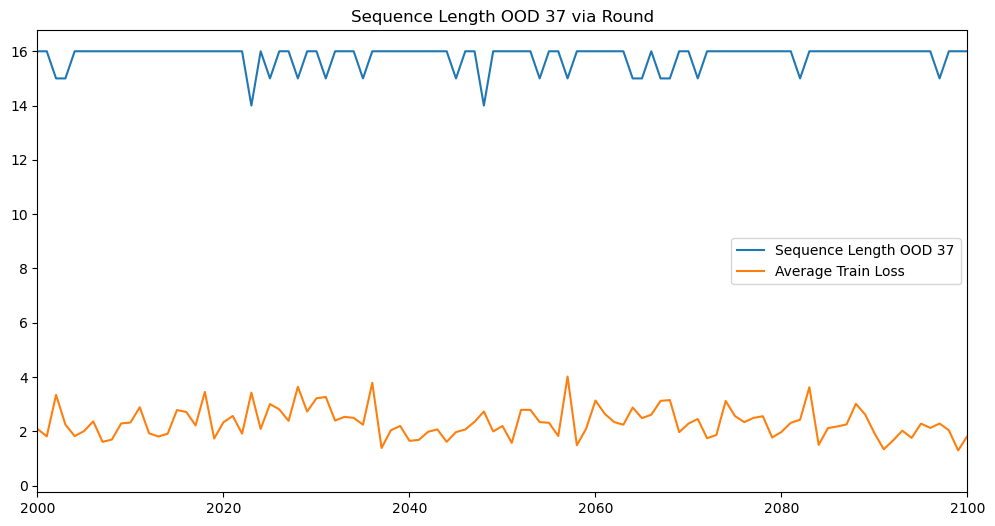

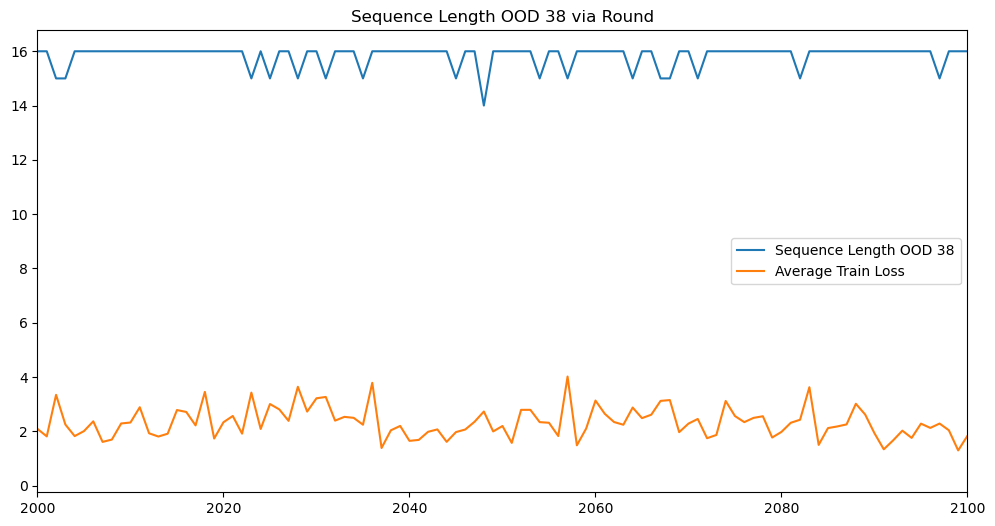

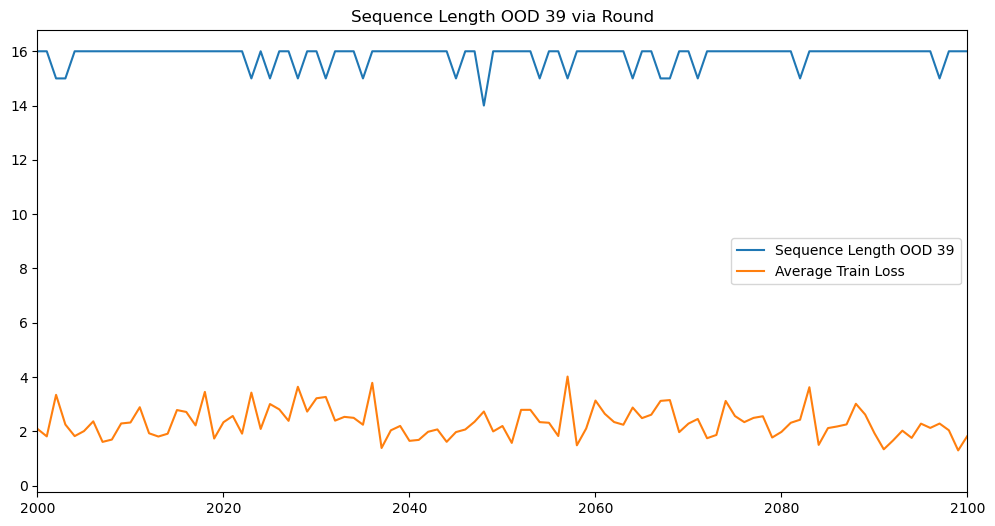

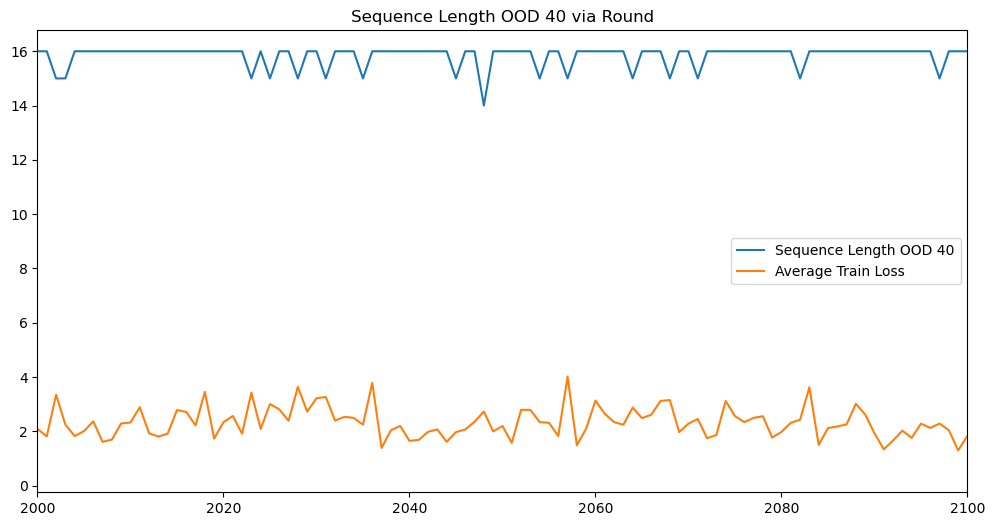

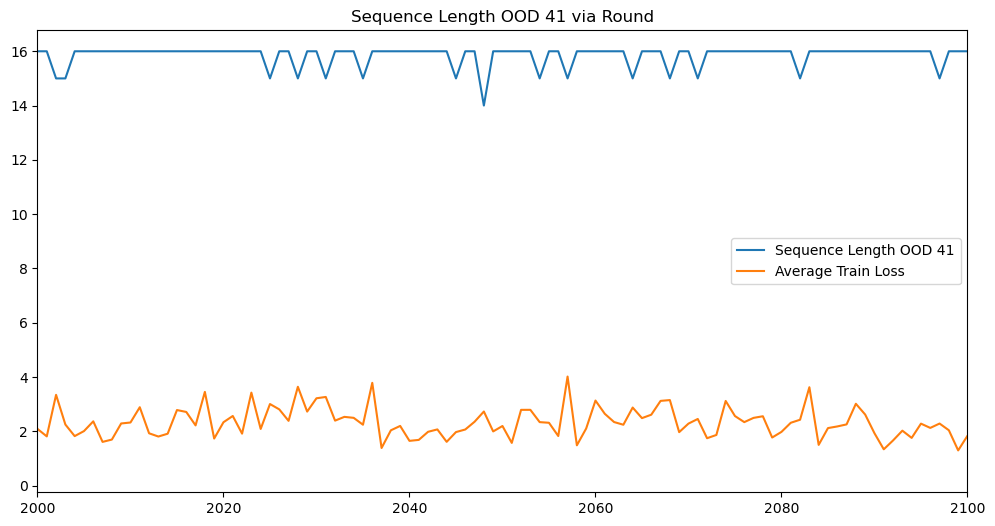

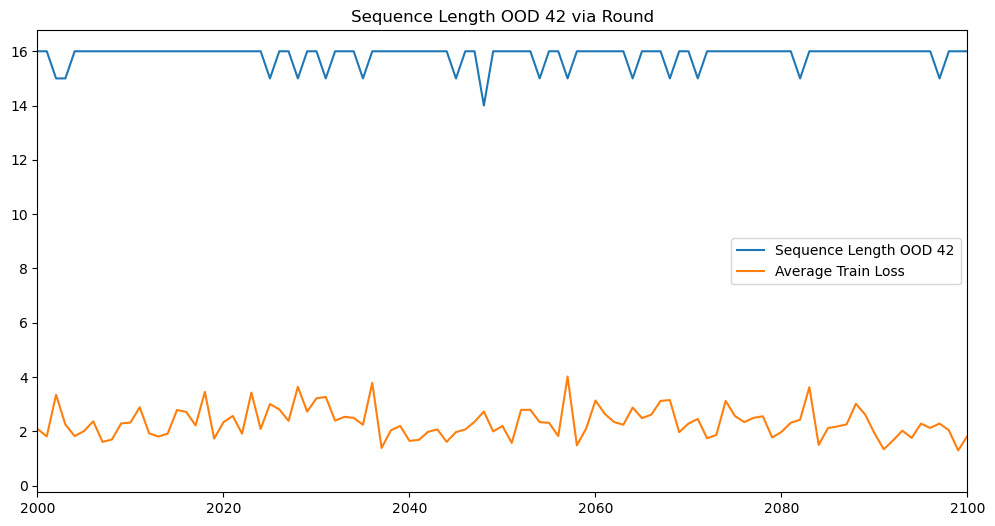

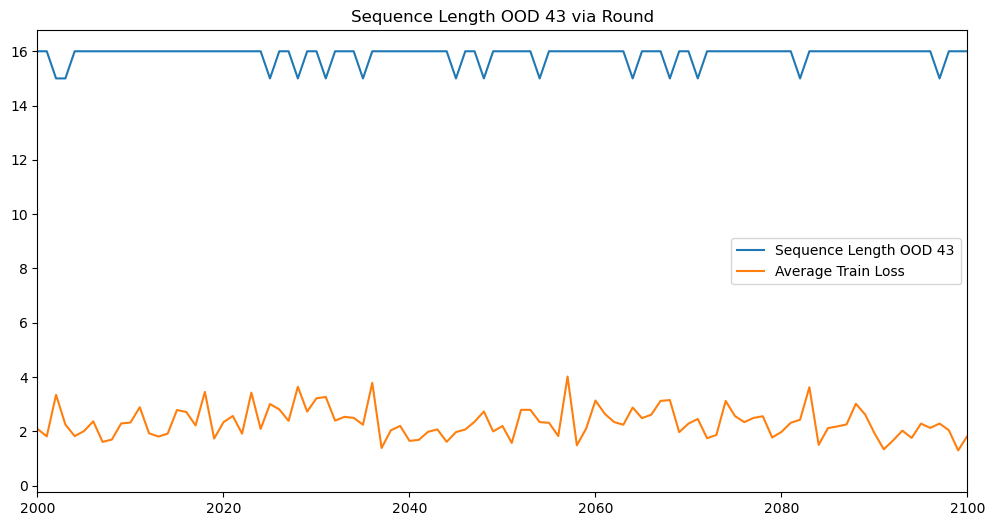

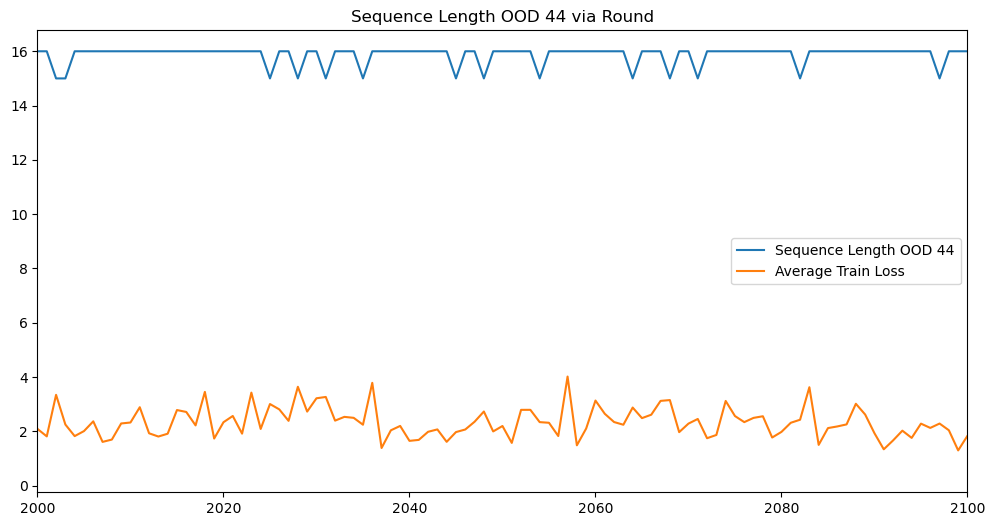

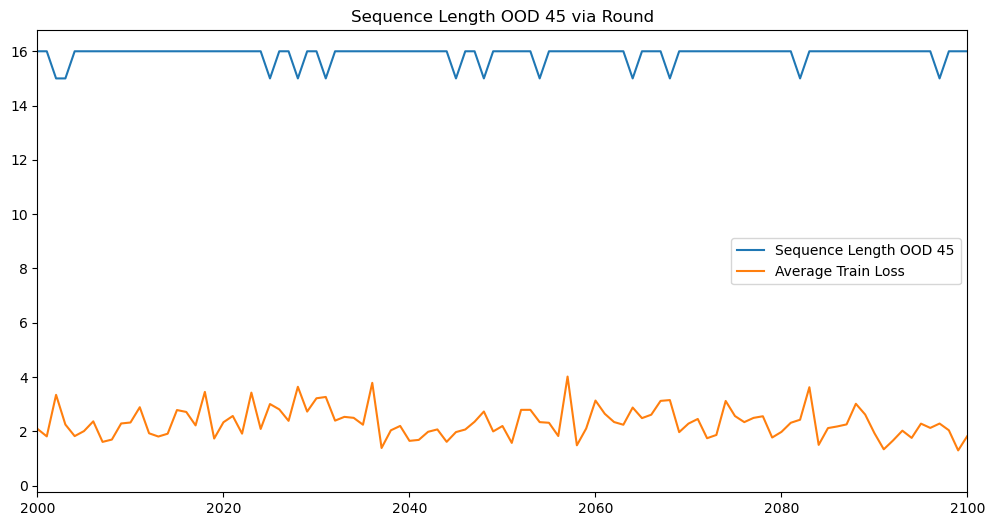

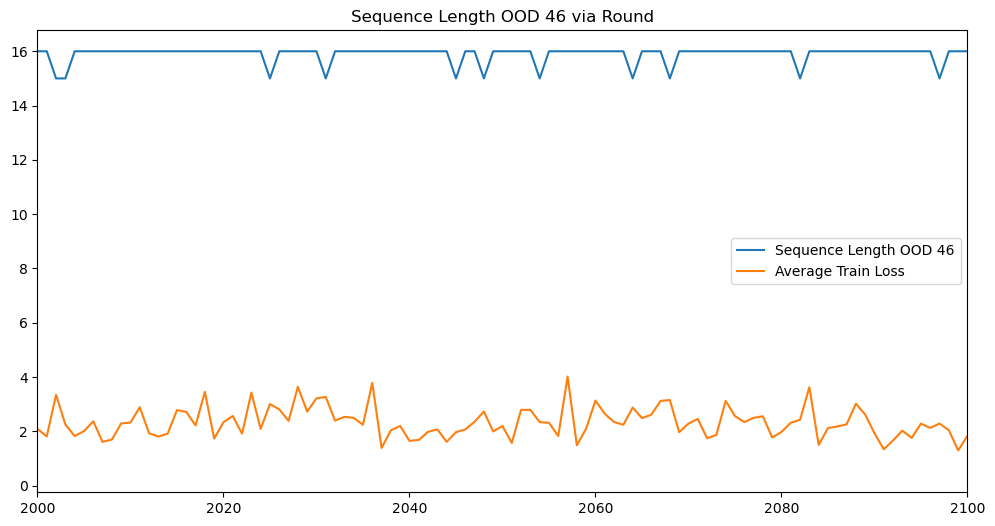

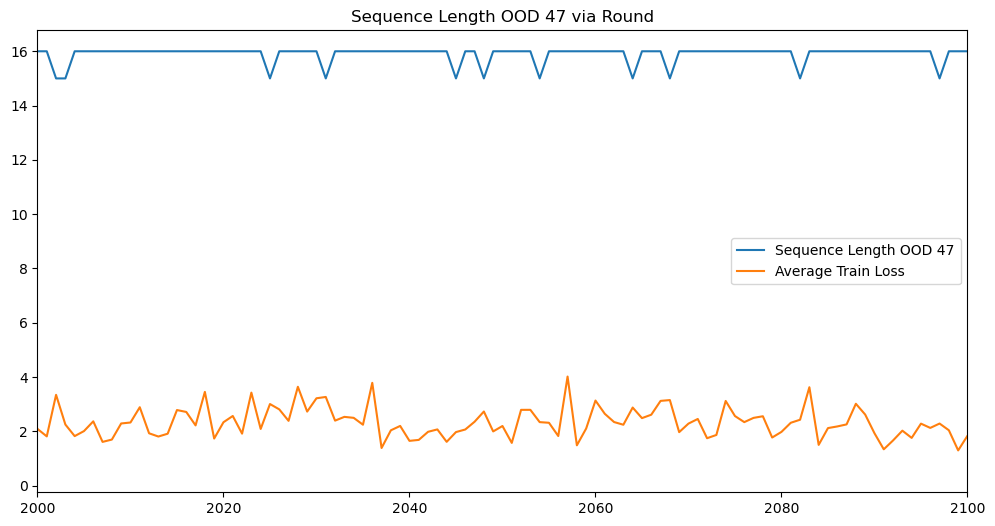

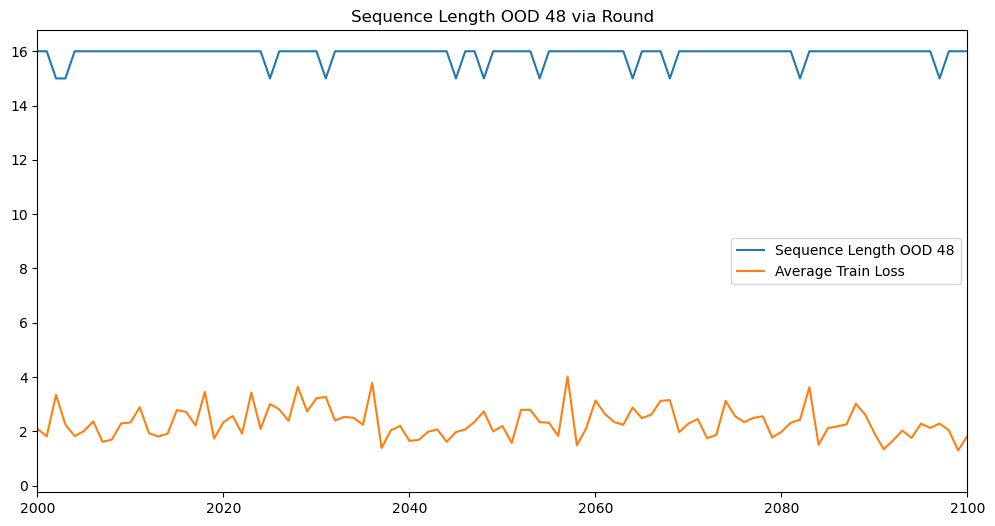

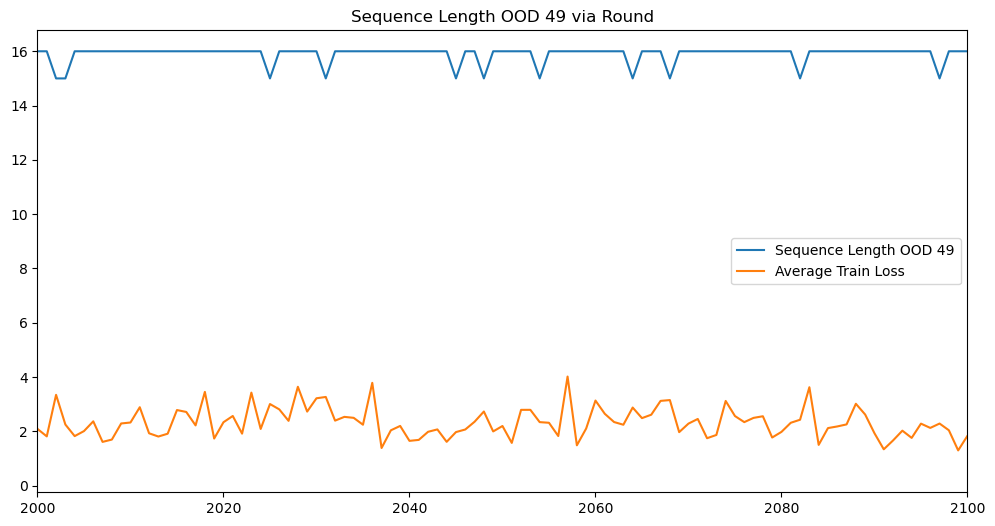

In [44]:
## ood_count and mean_train_loss via round plot

for i, current_sequence_length_via_round in enumerate(sequence_length_n_via_round) :
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(range(total_round_num), list(current_sequence_length_via_round.values()), label=f"Sequence Length OOD {i+min_sequence_length}")
    ax.plot(range(total_round_num), avg_train_loss, label='Average Train Loss')
    plt.title(f"Sequence Length OOD {i+min_sequence_length} via Round")
    plt.xlim(2000,2100)
    plt.legend()
    plt.show()

In [45]:
print(np.mean([sequence_length_ood_via_round[i] for i in range(total_round_num)]))
print(np.std([sequence_length_ood_via_round[i] for i in range(total_round_num)]))

0.0
0.0
